# 2D DPP conforming Galerkin FEM

In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd

# import petsc4py
# import numpy as np
# from scipy.sparse import csr_matrix
# from scipy.linalg import svd
# from scipy.sparse.linalg import svds
import logging

from perphil.forms.spaces import create_function_spaces
from perphil.mesh.builtin import create_mesh
from perphil.models.dpp.parameters import DPPParameters
from perphil.solvers.solver import (
    solve_dpp,
    solve_dpp_nonlinear,
    solve_dpp_picard,
    logger,
)
from perphil.solvers.parameters import (
    LINEAR_SOLVER_PARAMS,
    GMRES_PARAMS,
    FIELDSPLIT_LU_PARAMS,
    GMRES_JACOBI_PARAMS,
    RICHARDSON_SOLVER_PARAMS,
)
from perphil.utils.plotting import plot_2d_mesh, plot_scalar_field, plot_vector_field
from perphil.utils.manufactured_solutions import interpolate_exact
from perphil.utils.postprocessing import (
    split_dpp_solution,
    calculate_darcy_velocity_from_pressure,
    slice_along_x,
)

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

## Case 1

### Mesh

In [3]:
mesh = create_mesh(20, 20, quadrilateral=True)

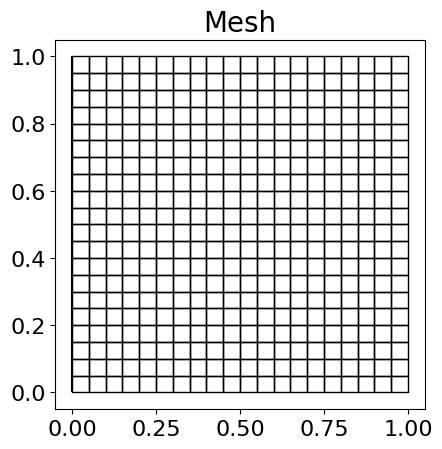

In [4]:
plot_2d_mesh(mesh)

### Exact solutions

In [5]:
U, V = create_function_spaces(
    mesh,
    velocity_deg=1,
    pressure_deg=1,
    velocity_family="CG",
    pressure_family="CG",
)

dpp_params = DPPParameters(k1=1.0, k2=1 / 1e2, beta=1.0, mu=1)
u1_exact, p1_exact, u2_exact, p2_exact = interpolate_exact(mesh, U, V, dpp_params)

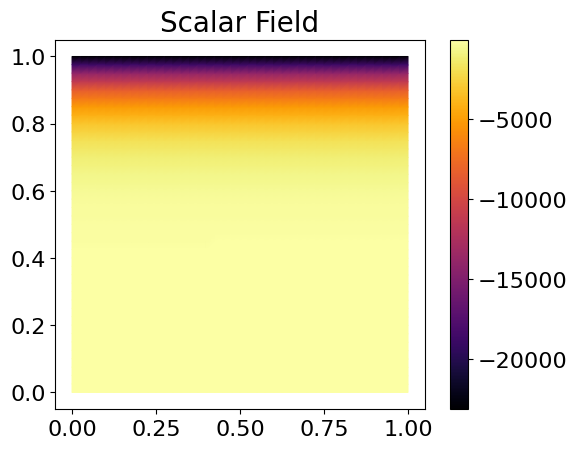

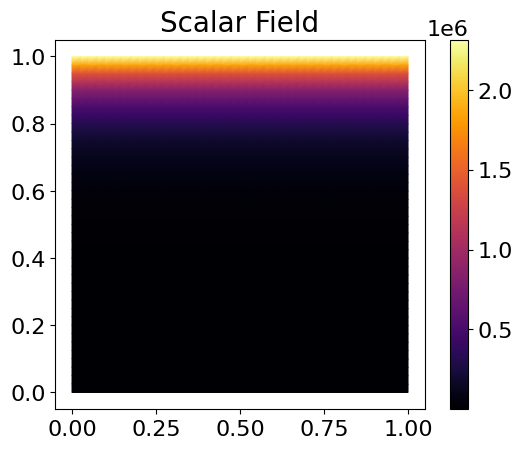

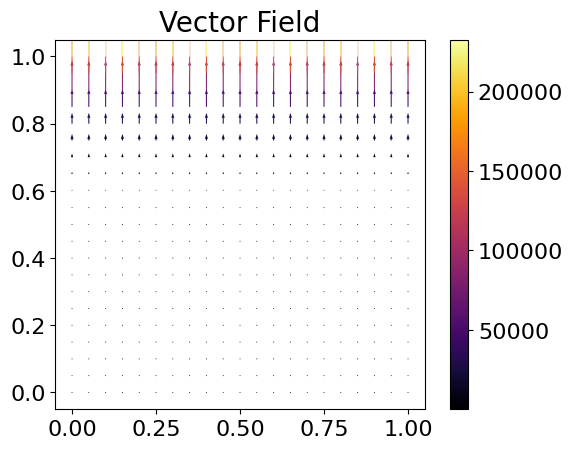

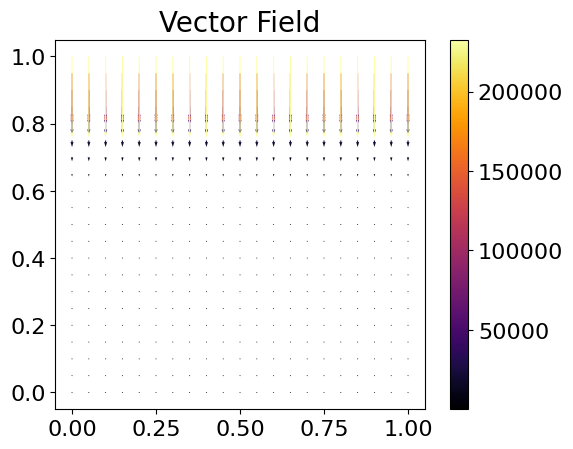

In [6]:
plot_scalar_field(p1_exact)
plot_scalar_field(p2_exact)
plot_vector_field(u1_exact)
plot_vector_field(u2_exact)

### Conforming Galerkin FEM approximations

#### Monolithic (fully coupled) approximation

In [7]:
W = V * V  # Mixed function space with both scales

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

solver_parameters = LINEAR_SOLVER_PARAMS
solution_monolithic = solve_dpp(W, dpp_params, bcs, solver_parameters=solver_parameters)
p1_monolithic, p2_monolithic = split_dpp_solution(solution_monolithic)

u1_monolithic = calculate_darcy_velocity_from_pressure(p1_monolithic, dpp_params.k1)

u2_monolithic = calculate_darcy_velocity_from_pressure(p2_monolithic, dpp_params.k2)

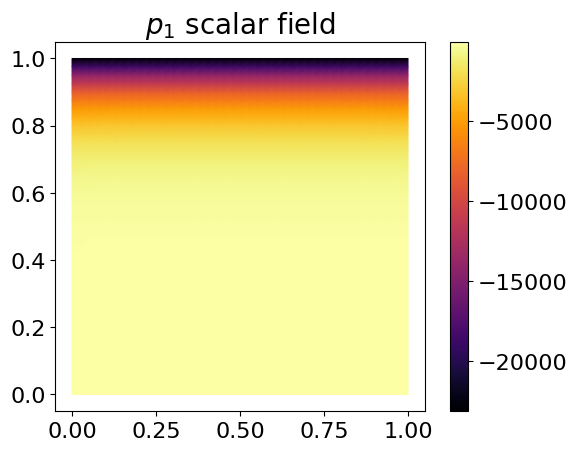

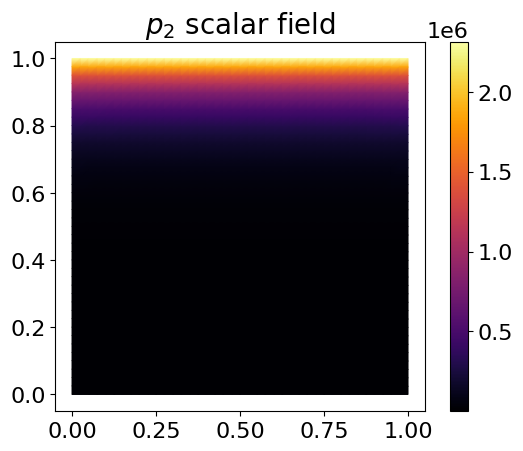

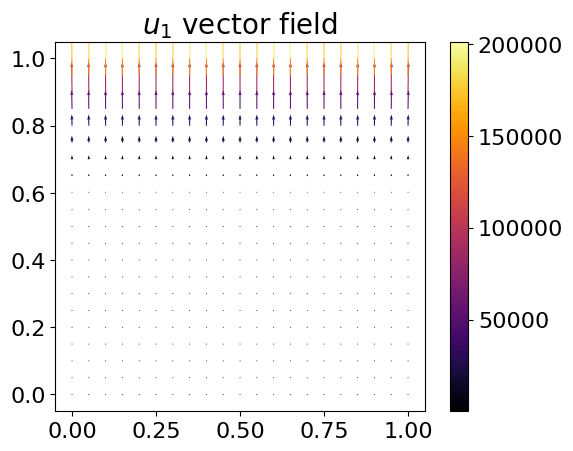

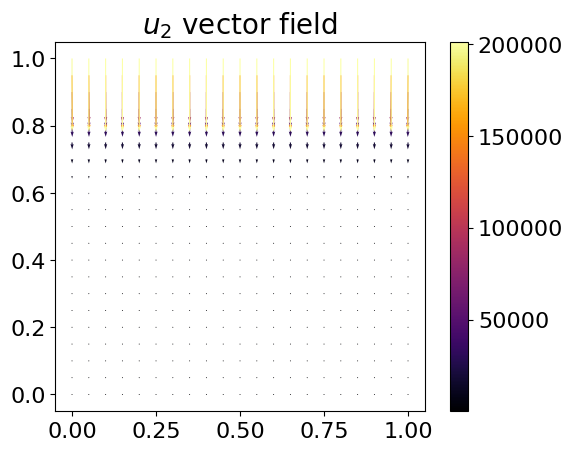

In [8]:
plot_scalar_field(p1_monolithic, title=r"$p_1$ scalar field")
plot_scalar_field(p2_monolithic, title=r"$p_2$ scalar field")
plot_vector_field(u1_monolithic, title=r"$u_1$ vector field")
plot_vector_field(u2_monolithic, title=r"$u_2$ vector field")

In [9]:
x_mid_point = 0.5
y_points, p1_mono_at_x_mid_point = slice_along_x(p1_monolithic, x_value=x_mid_point)
_, p1_exact_at_x_mid_point = slice_along_x(p1_exact, x_value=x_mid_point)
_, p2_mono_at_x_mid_point = slice_along_x(p2_monolithic, x_value=x_mid_point)
_, p2_exact_at_x_mid_point = slice_along_x(p2_exact, x_value=x_mid_point)

y_points, p1_mono_at_x_mid_point, p2_mono_at_x_mid_point

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([-1.00000000e+00, -1.32080698e+00, -2.05751689e+00, -3.47019887e+00,
        -5.99338652e+00, -1.03488166e+01, -1.77339423e+01, -3.01359397e+01,
        -5.08540155e+01, -8.53677551e+01, -1.42780496e+02, -2.38218340e+02,
        -3.96817373e+02, -6.60350337e+02, -1.09823971e+03, -1.82586021e+03,
        -3.03495493e+03, -5.04418188e+03, -8.38311376e+03, -1.39318315e+04,
        -2.31529069e+04]),
 array([1.00000000e+02, 1.56202030e+02, 2.53400406e+02, 4.17022720e+02,
        6.89971898e+02, 1.14391363e+03, 1.89814020e+03, 3.15098226e+03,
        5.23204922e+03, 8.68907161e+03, 1.44322441e+04, 2.39741301e+04,
        3.98283850e+04, 6.61724220e+04, 1.09948717e+05, 1.82695053e+05,
        3.03586126e+05, 5.04488191e+05, 8.38359025e+05, 1.39320727e+06,
        2.31529069e+06]))

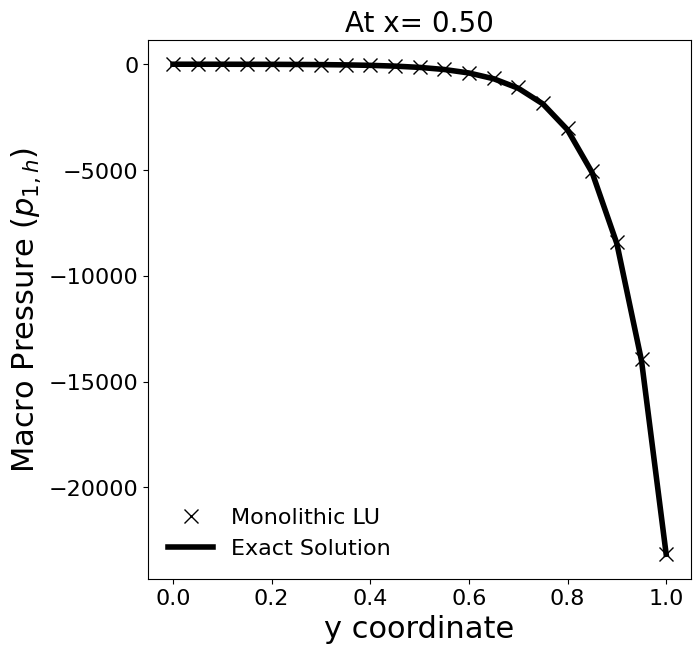

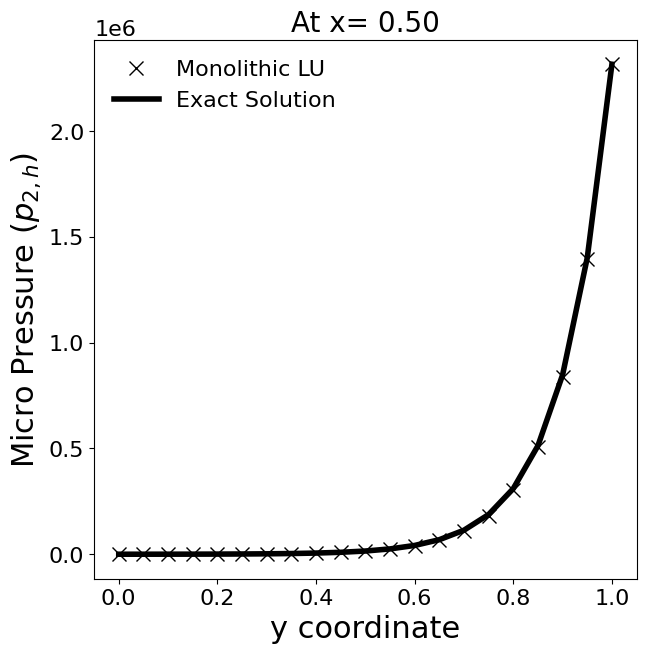

In [10]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Scale-splitting

Pre-conditioner by scale:

In [11]:
solver_monitoring_param = {
    "ksp_monitor": None,
}
solver_parameters = {**GMRES_PARAMS, **FIELDSPLIT_LU_PARAMS, **solver_monitoring_param}
solution_preconditioned = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
p1_preconditioned, p2_preconditioned = split_dpp_solution(solution_preconditioned)

u1_preconditioned = calculate_darcy_velocity_from_pressure(
    p1_preconditioned, dpp_params.k1
)

u2_preconditioned = calculate_darcy_velocity_from_pressure(
    p2_preconditioned, dpp_params.k2
)

    Residual norms for dpp_ solve.
    0 KSP Residual norm 7.577694309683e+06
    1 KSP Residual norm 1.156465033078e+05
    2 KSP Residual norm 1.748227203047e+03
    3 KSP Residual norm 1.068809478885e+01
    4 KSP Residual norm 2.490739680499e-02
    5 KSP Residual norm 2.704908412806e-05
    6 KSP Residual norm 2.009859815285e-08


In [12]:
solver_monitoring_param = {
    "ksp_monitor": None,
}
solver_parameters = {**GMRES_JACOBI_PARAMS, **solver_monitoring_param}
solution_gmres_jacobi = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
p1_gmres_jacobi, p2_gmres_jacobi = split_dpp_solution(solution_gmres_jacobi)

u1_gmres_jacobi = calculate_darcy_velocity_from_pressure(p1_gmres_jacobi, dpp_params.k1)

u2_gmres_jacobi = calculate_darcy_velocity_from_pressure(p2_gmres_jacobi, dpp_params.k2)

    Residual norms for dpp_ solve.
    0 KSP Residual norm 3.656607590335e+06
    1 KSP Residual norm 1.439834371331e+06
    2 KSP Residual norm 7.231201180569e+05
    3 KSP Residual norm 3.966145931345e+05
    4 KSP Residual norm 2.258375976969e+05
    5 KSP Residual norm 1.310187788250e+05
    6 KSP Residual norm 7.665578627384e+04
    7 KSP Residual norm 4.499210209080e+04
    8 KSP Residual norm 2.645627056021e+04
    9 KSP Residual norm 1.560928785340e+04
   10 KSP Residual norm 9.071788171797e+03
   11 KSP Residual norm 5.330059144625e+03
   12 KSP Residual norm 3.127173309080e+03
   13 KSP Residual norm 1.833036078861e+03
   14 KSP Residual norm 1.077155782483e+03
   15 KSP Residual norm 6.318639015824e+02
   16 KSP Residual norm 3.700865341193e+02
   17 KSP Residual norm 2.166636889922e+02
   18 KSP Residual norm 1.261787119404e+02
   19 KSP Residual norm 3.774602225960e+01
   20 KSP Residual norm 1.856329177531e+01
   21 KSP Residual norm 1.076023131037e+01
   22 KSP Residual 

In [13]:
y_points, p1_pc_at_x_mid_point = slice_along_x(p1_preconditioned, x_value=x_mid_point)
_, p2_pc_at_x_mid_point = slice_along_x(p2_preconditioned, x_value=x_mid_point)

y_points, p1_pc_at_x_mid_point, p2_pc_at_x_mid_point

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([-1.00000000e+00, -1.32080698e+00, -2.05751689e+00, -3.47019887e+00,
        -5.99338651e+00, -1.03488166e+01, -1.77339423e+01, -3.01359396e+01,
        -5.08540155e+01, -8.53677551e+01, -1.42780496e+02, -2.38218340e+02,
        -3.96817373e+02, -6.60350337e+02, -1.09823971e+03, -1.82586021e+03,
        -3.03495493e+03, -5.04418188e+03, -8.38311376e+03, -1.39318315e+04,
        -2.31529069e+04]),
 array([1.00000000e+02, 1.56202030e+02, 2.53400406e+02, 4.17022720e+02,
        6.89971898e+02, 1.14391363e+03, 1.89814020e+03, 3.15098226e+03,
        5.23204922e+03, 8.68907161e+03, 1.44322441e+04, 2.39741301e+04,
        3.98283850e+04, 6.61724220e+04, 1.09948717e+05, 1.82695053e+05,
        3.03586126e+05, 5.04488191e+05, 8.38359025e+05, 1.39320727e+06,
        2.31529069e+06]))

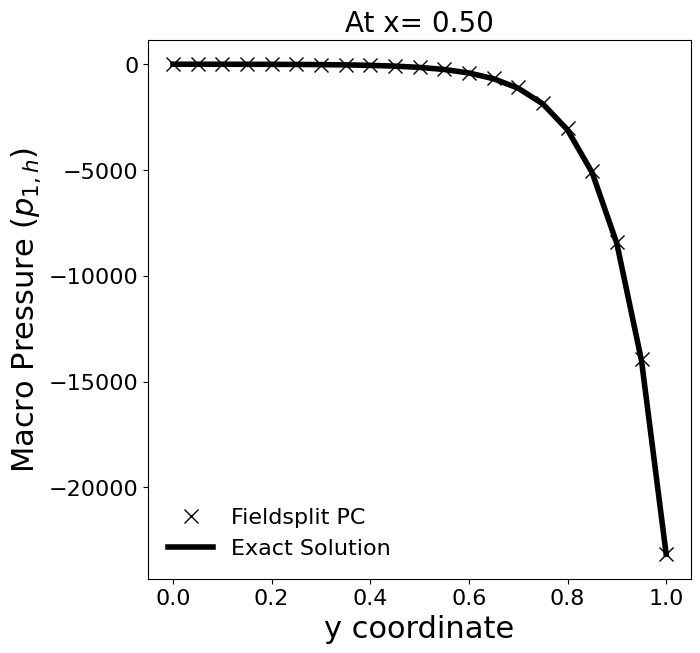

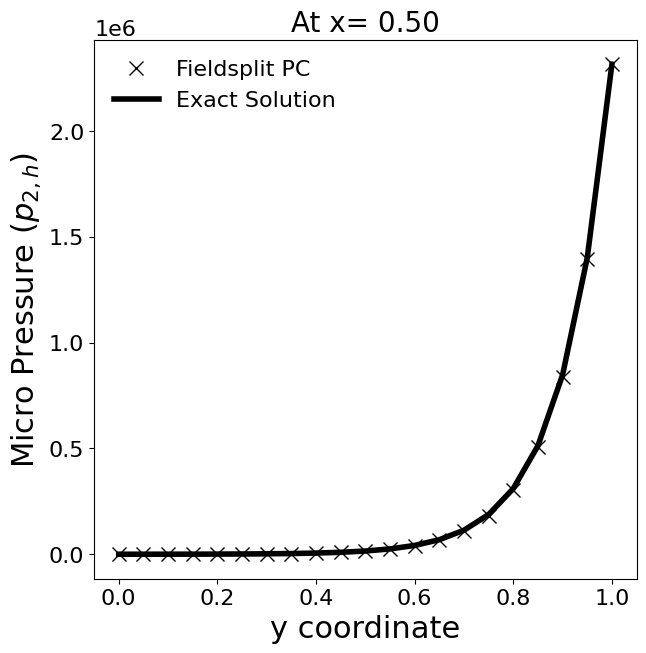

In [14]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

PETSc's Richardson iterations:

In [15]:
solver_monitoring_param = {
    "snes_monitor": None,
}
solver_parameters = {**RICHARDSON_SOLVER_PARAMS, **solver_monitoring_param}
solution_richardson = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
p1_richardson, p2_richardson = split_dpp_solution(solution_richardson)

u1_richardson = calculate_darcy_velocity_from_pressure(p1_richardson, dpp_params.k1)

u2_richardson = calculate_darcy_velocity_from_pressure(p2_richardson, dpp_params.k2)

  0 SNES Function norm 1.436364896905e+05
  1 SNES Function norm 1.118579121757e+05
  2 SNES Function norm 1.049699684507e+05
  3 SNES Function norm 1.016953010160e+05
  4 SNES Function norm 9.954313799658e+04
  5 SNES Function norm 9.786914726762e+04
  6 SNES Function norm 9.644108091641e+04
  7 SNES Function norm 9.515714883233e+04
  8 SNES Function norm 9.396646068527e+04
  9 SNES Function norm 9.284102164514e+04
 10 SNES Function norm 9.176426131198e+04
 11 SNES Function norm 9.072578032257e+04
 12 SNES Function norm 8.971872898685e+04
 13 SNES Function norm 8.873840683810e+04
 14 SNES Function norm 8.778147144152e+04
 15 SNES Function norm 8.684547002207e+04
 16 SNES Function norm 8.592855097187e+04
 17 SNES Function norm 8.502927999182e+04
 18 SNES Function norm 8.414651940201e+04
 19 SNES Function norm 8.327934684366e+04
 20 SNES Function norm 8.242699925417e+04
 21 SNES Function norm 8.158883346950e+04
 22 SNES Function norm 8.076429801292e+04
 23 SNES Function norm 7.995291256

In [16]:
y_points, p1_richardson_at_x_mid_point = slice_along_x(
    p1_richardson, x_value=x_mid_point
)
_, p2_richardson_at_x_mid_point = slice_along_x(p2_richardson, x_value=x_mid_point)

y_points, p1_richardson_at_x_mid_point, p2_richardson_at_x_mid_point

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([-1.00000000e+00, -1.66034719e+00, -2.73189970e+00, -4.46982119e+00,
        -7.30335342e+00, -1.19484337e+01, -1.95961684e+01, -3.22269004e+01,
        -5.31326912e+01, -8.77859557e+01, -1.45283227e+02, -2.40744643e+02,
        -3.99301680e+02, -6.62724340e+02, -1.10043469e+03, -1.82780974e+03,
        -3.03659771e+03, -5.04546463e+03, -8.38399386e+03, -1.39322792e+04,
        -2.31529069e+04]),
 array([1.00000000e+02, 1.51017819e+02, 2.42994158e+02, 4.01332530e+02,
        6.68938380e+02, 1.11751752e+03, 1.86644810e+03, 3.11419646e+03,
        5.19055664e+03, 8.64348593e+03, 1.43834349e+04, 2.39232331e+04,
        3.97767884e+04, 6.61217266e+04, 1.09900669e+05, 1.82651454e+05,
        3.03548728e+05, 5.04458577e+05, 8.38338500e+05, 1.39319677e+06,
        2.31529069e+06]))

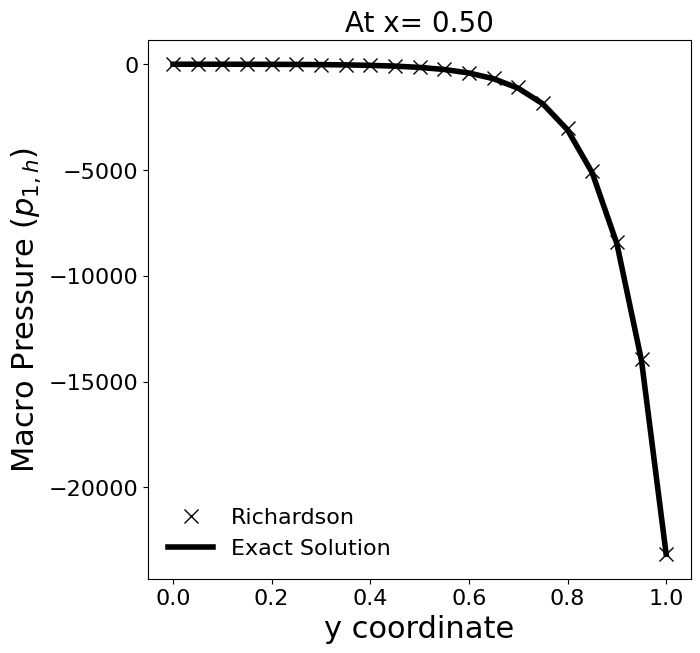

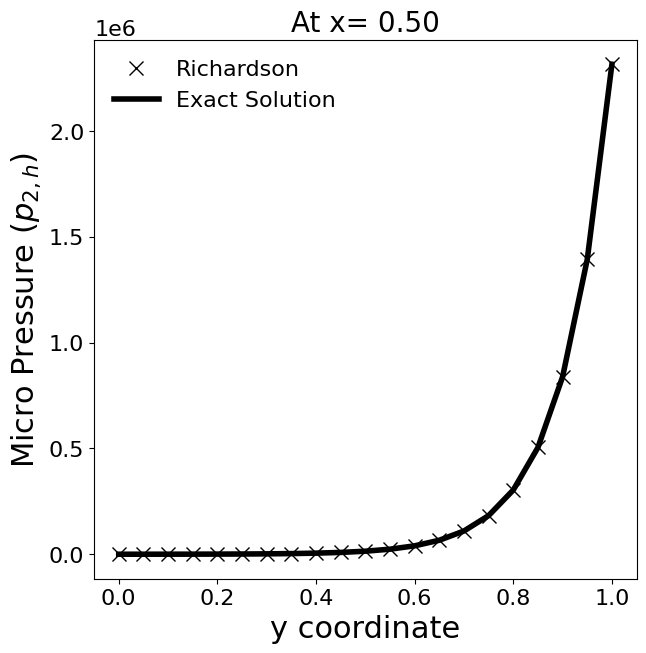

In [17]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_richardson_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Richardson"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Richardson")
plt.plot(y_points, p2_richardson_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations:

In [18]:
# Set the logger in Picard loop-based to INFO level.
# This way, iterations are displayed in cell outputs.
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(levelname)s %(name)s: %(message)s"))
logger.addHandler(handler)

In [19]:
solver_parameters = {
    **LINEAR_SOLVER_PARAMS,
}
bc_macro = fd.DirichletBC(V, p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(V, p2_exact, "on_boundary")
p1_picard, p2_picard = solve_dpp_picard(
    V,
    V,
    dpp_params,
    bcs_macro=[bc_macro],
    bcs_micro=[bc_micro],
    macro_solver_parameters=solver_parameters,
    micro_solver_parameters=solver_parameters,
)

u1_picard = calculate_darcy_velocity_from_pressure(p1_picard, dpp_params.k1)

u2_picard = calculate_darcy_velocity_from_pressure(p2_picard, dpp_params.k2)

/home/diego/perphil/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/home/diego/perphil/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` 

In [20]:
y_points, p1_picard_at_x_mid_point = slice_along_x(p1_picard, x_value=x_mid_point)
_, p2_picard_at_x_mid_point = slice_along_x(p2_picard, x_value=x_mid_point)

y_points, p1_picard_at_x_mid_point, p2_picard_at_x_mid_point

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([-1.00000000e+00, -1.32080698e+00, -2.05751689e+00, -3.47019887e+00,
        -5.99338652e+00, -1.03488166e+01, -1.77339423e+01, -3.01359397e+01,
        -5.08540155e+01, -8.53677551e+01, -1.42780496e+02, -2.38218340e+02,
        -3.96817373e+02, -6.60350337e+02, -1.09823971e+03, -1.82586021e+03,
        -3.03495493e+03, -5.04418188e+03, -8.38311376e+03, -1.39318315e+04,
        -2.31529069e+04]),
 array([1.00000000e+02, 1.56202030e+02, 2.53400406e+02, 4.17022720e+02,
        6.89971898e+02, 1.14391363e+03, 1.89814020e+03, 3.15098226e+03,
        5.23204922e+03, 8.68907161e+03, 1.44322441e+04, 2.39741301e+04,
        3.98283850e+04, 6.61724220e+04, 1.09948717e+05, 1.82695053e+05,
        3.03586126e+05, 5.04488191e+05, 8.38359025e+05, 1.39320727e+06,
        2.31529069e+06]))

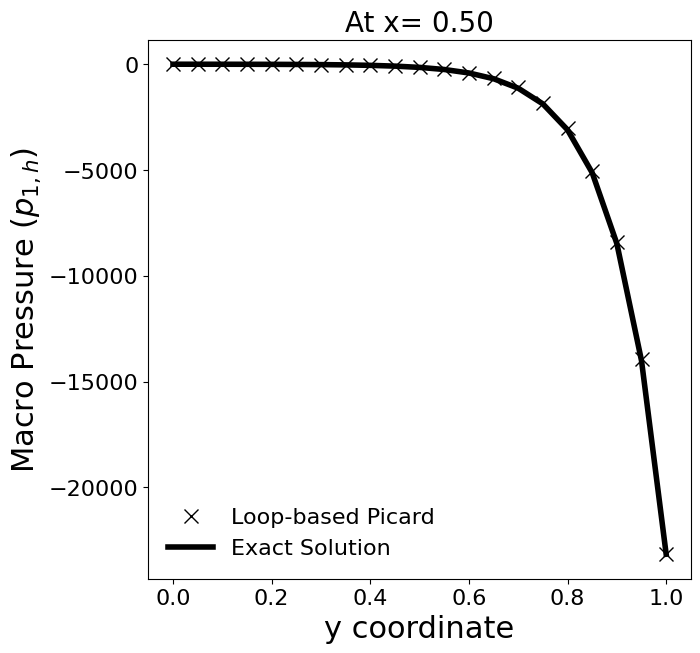

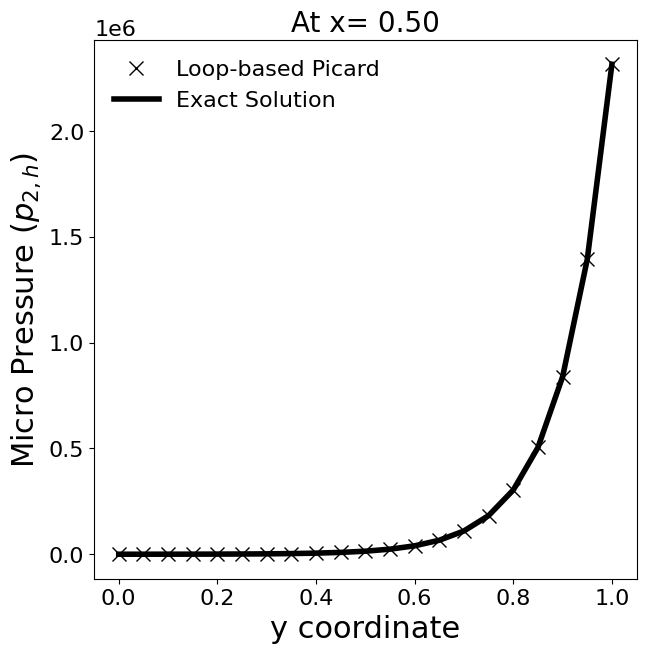

In [21]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points,
    p1_picard_at_x_mid_point,
    "x",
    ms=10,
    lw=4,
    c="k",
    label="Loop-based Picard",
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Loop-based Picard"
)
plt.plot(y_points, p2_picard_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Conditioning Analysis

##### Monolithic system

Define the variational form:

In [22]:
# # Approximation degree
# degree = 1

# # Function space declaration
# pressure_family = "CG"
# velocity_family = "CG"
# U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
# V = fd.FunctionSpace(mesh, pressure_family, degree)
# W = V * V

# # Trial and test functions
# dpp_fields = fd.Function(W)
# p1, p2 = fd.TrialFunctions(W)
# q1, q2 = fd.TestFunctions(W)

# # Forcing function
# f = fd.Constant(0.0)

# # Dirichlet BCs
# bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
# bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
# bcs = [bc_macro, bc_micro]

# # Variational form
# ## Mass transfer term
# xi = -beta / mu * (p1 - p2)

# ## Macro terms
# a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
# L = f * q1 * dx

# ## Micro terms
# a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
# L += f * q2 * dx

# # Isolate LHS
# F = a - L
# a_form = fd.lhs(F)

Assemble and get the associated matrix:

In [23]:
# A = fd.assemble(a_form, bcs=bcs, mat_type="aij")
# petsc_mat = A.M.handle
# is_symmetric = petsc_mat.isSymmetric(tol=1e-8)
# size = petsc_mat.getSize()
# Mnp = csr_matrix(petsc_mat.getValuesCSR()[::-1], shape=size)

Get DoF number and clean matrix:

In [24]:
# Mnp.eliminate_zeros()
# nnz = Mnp.nnz
# number_of_dofs = W.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom: {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

Convenient function to calculate spectral Condition Number using `scipy`:

In [25]:
# def calculate_condition_number(
#     A: petsc4py.PETSc.Mat,
#     num_of_factors: int,
#     use_sparse: bool = False,
#     zero_tol: float = 1e-5,
# ) -> float | np.float64:
#     size = A.getSize()
#     Mnp = csr_matrix(A.getValuesCSR()[::-1], shape=size)
#     Mnp.eliminate_zeros()

#     if use_sparse:
#         singular_values = svds(
#             A=Mnp,
#             k=num_of_factors,
#             which="LM",
#             maxiter=5000,
#             return_singular_vectors=False,
#             solver="lobpcg",
#         )
#     else:
#         M = Mnp.toarray()
#         singular_values = svd(M, compute_uv=False, check_finite=False)

#     singular_values = singular_values[singular_values > zero_tol]

#     condition_number = singular_values.max() / singular_values.min()

#     return condition_number

Condition Number for the monolithic (all scales) matrix system:

In [26]:
# monolithic_system_condition_number = calculate_condition_number(
#     A=petsc_mat, num_of_factors=num_of_factors
# )

# print(f"Monolithic system Condition Number: {monolithic_system_condition_number}")

##### Scale-splitting

In [27]:
# # Approximation degree
# degree = 1

# # Function space declaration
# pressure_family = "CG"
# velocity_family = "CG"
# U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
# V = fd.FunctionSpace(mesh, pressure_family, degree)

# # Trial and test functions
# p1 = fd.TrialFunction(V)
# p2 = fd.TrialFunction(V)
# q1 = fd.TestFunction(V)
# q2 = fd.TestFunction(V)

# # Forcing function
# f = fd.Constant(0.0)

# # Dirichlet BCs
# bc_macro = fd.DirichletBC(V, p1_exact, "on_boundary")
# bc_micro = fd.DirichletBC(V, p2_exact, "on_boundary")

# # Staggered pressures
# p1_old = fd.interpolate(fd.Constant(0), V)
# p2_old = fd.interpolate(fd.Constant(0), V)

# # Variational form
# ## Mass transfer term
# xi_macro = -beta / mu * (p1 - p2_old)
# xi_micro = -beta / mu * (p1_old - p2)

# ## Macro terms
# a_1 = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi_macro * q1 * dx
# L_1 = f * q1 * dx
# F_macro = a_1 - L_1
# a_macro = fd.lhs(F_macro)
# L_macro = fd.rhs(F_macro)

# ## Micro terms
# a_2 = (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi_micro * q2 * dx
# L_2 = f * q2 * dx
# F_micro = a_2 - L_2
# a_micro = fd.lhs(F_micro)
# L_micro = fd.rhs(F_micro)

In [28]:
# # Macro
# A_macro = fd.assemble(a_macro, bcs=bc_macro, mat_type="aij")
# petsc_mat_macro = A_macro.M.handle
# is_symmetric_macro = petsc_mat_macro.isSymmetric(tol=1e-8)
# size_macro = petsc_mat_macro.getSize()
# Mnp_macro = csr_matrix(petsc_mat_macro.getValuesCSR()[::-1], shape=size_macro)

# # Micro
# A_micro = fd.assemble(a_micro, bcs=bc_micro, mat_type="aij")
# petsc_mat_micro = A_micro.M.handle
# is_symmetric_micro = petsc_mat_micro.isSymmetric(tol=1e-8)
# size_micro = petsc_mat_micro.getSize()
# Mnp_micro = csr_matrix(petsc_mat_micro.getValuesCSR()[::-1], shape=size_micro)

In [29]:
# Mnp_macro.eliminate_zeros()
# nnz = Mnp_macro.nnz
# number_of_dofs = V.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom (Macro): {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

In [30]:
# Mnp_micro.eliminate_zeros()
# nnz = Mnp_micro.nnz
# number_of_dofs = V.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom (Micro): {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

In [31]:
# macro_system_condition_number = calculate_condition_number(
#     A=petsc_mat_macro, num_of_factors=num_of_factors
# )
# micro_system_condition_number = calculate_condition_number(
#     A=petsc_mat_micro, num_of_factors=num_of_factors
# )

# print(f"Macro system Condition Number: {macro_system_condition_number}")
# print(f"Micro system Condition Number: {micro_system_condition_number}")